# CNN Architecture Methods

In [1]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

### Load the MNIST Dataset

In [3]:
# Any data augmentation should be added to training
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Test data should have normalization applied, but no augmentation
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Download the MNIST data and lazily apply the transformation pipeline
train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

# Setup data loaders
# Note: Iterating through the dataloader yields batches of (inputs, targets)
# where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

### Visualize the MNIST Dataset

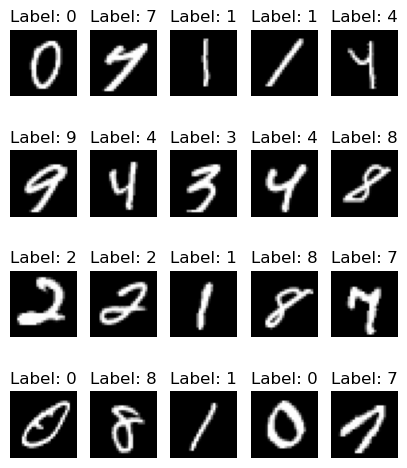

In [4]:
# Plot examples of transformations
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for i, ax in enumerate(axs.flatten(), start=1000):
    (image, label) = train_data[i]

    # Save this data for later
    plot_images.append(image)
    plot_labels.append(label)

    # Plot each image
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

### Define the Training and Test Loops

In [5]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()

        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [6]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

## Strategies for Achieving >99% Test Accuracy on MNIST with CNNs

### Plot function

In [7]:
def plot(train_losses, test_losses, train_metrics,test_metrics):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(train_losses, c="r", label="Train loss")
    axs[0].plot(test_losses, c="b", label="Test loss")
    axs[0].legend()
    axs[0].set_xlabel("Epochs")
    axs[0].set_title("Loss over epochs")

    axs[1].plot(train_metrics, "o-", c="r", label="Train accuracy")
    axs[1].plot(test_metrics, "o-", c="b", label="Test accuracy")
    axs[1].legend()
    axs[1].set_xlabel("Epochs")
    axs[1].set_title("Accuracy over epochs")

## Convolutional Networks

In [8]:
# Basic Parmeters that are used
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5

### Simple CNN 
    (1 conv + 1FC) with padding=1

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.fc1 = nn.Linear(32*28*28, 10)  # flatten conv output

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        # print(f'convo layer shape {x.shape}')
        
        x = x.view(x.size(0), -1)  # Flatten # [batch, 32*28*28]
        # print(f'faltten shape {x.shape}')
        
        x = F.relu(self.fc1(x)) # final output [batch, 10]
        # print(f'output {x.shape}')
        return x

Epoch 1 done. Average train loss = 1.59, average train accuracy = 36.270%
Epoch 1 done. Average test loss = 1.48, average test accuracy = 38.330%
Epoch 2 done. Average train loss = 1.47, average train accuracy = 38.482%
Epoch 2 done. Average test loss = 1.46, average test accuracy = 38.540%
Epoch 3 done. Average train loss = 1.44, average train accuracy = 38.790%
Epoch 3 done. Average test loss = 1.44, average test accuracy = 38.720%
Epoch 4 done. Average train loss = 1.44, average train accuracy = 38.918%
Epoch 4 done. Average test loss = 1.44, average test accuracy = 38.870%
Epoch 5 done. Average train loss = 1.43, average train accuracy = 38.990%
Epoch 5 done. Average test loss = 1.44, average test accuracy = 38.670%


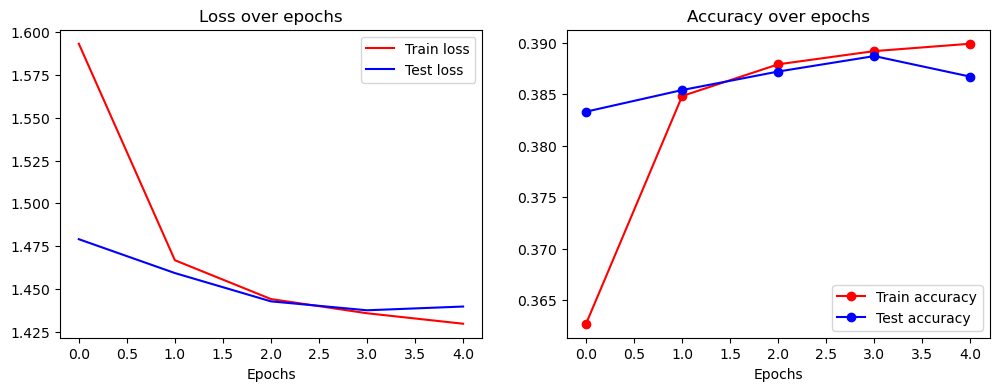

In [10]:
torch.manual_seed(0)

model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Baseline CNN 
    (2 conv + 2FC)

In [11]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3) 
        
        self.fc1 = nn.Linear(64*24*24, 128) # flatten conv output
        self.fc2 = nn.Linear(128, 10) # output set to 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        # print(x.shape)
        
        x = F.relu(self.conv2(x)) # ReLU function for layer 2
        # print(x.shape)
 
        x = x.view(x.size(0), -1) # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        # print(x.shape)

        x = self.fc2(x) # final output [batch, 10]
        return x

Epoch 1 done. Average train loss = 0.23, average train accuracy = 93.100%
Epoch 1 done. Average test loss = 0.06, average test accuracy = 98.170%
Epoch 2 done. Average train loss = 0.05, average train accuracy = 98.580%
Epoch 2 done. Average test loss = 0.05, average test accuracy = 98.510%
Epoch 3 done. Average train loss = 0.03, average train accuracy = 99.102%
Epoch 3 done. Average test loss = 0.04, average test accuracy = 98.640%
Epoch 4 done. Average train loss = 0.02, average train accuracy = 99.448%
Epoch 4 done. Average test loss = 0.04, average test accuracy = 98.780%
Epoch 5 done. Average train loss = 0.01, average train accuracy = 99.647%
Epoch 5 done. Average test loss = 0.05, average test accuracy = 98.570%


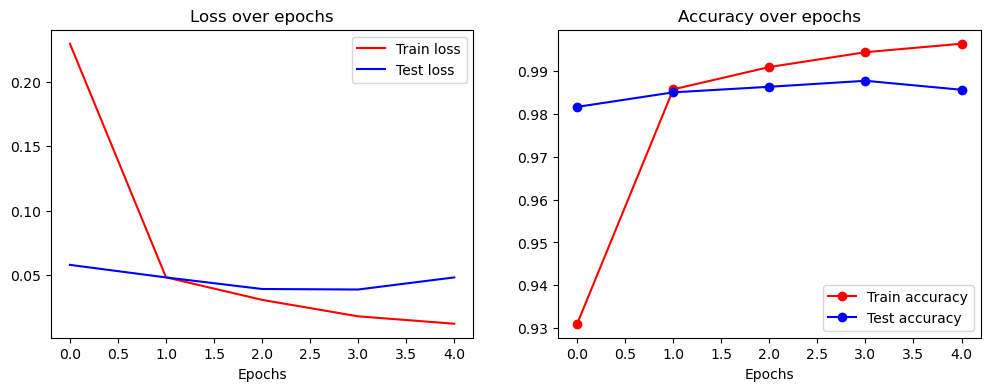

In [12]:
torch.manual_seed(0)

model = BaseCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Baseline CNN with Pooling
    (2 conv + 2FC)

In [13]:
class BasePoolingCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3) 
        
        self.pool = nn.MaxPool2d(2, 2) #Pooling (2,2)
        
        self.fc1 = nn.Linear(64*5*5, 128) # flatten conv output
        self.fc2 = nn.Linear(128, 10) # output set to 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        x = self.pool(x)
        # print(x.shape)
        
        x = F.relu(self.conv2(x)) # ReLU function for layer 2
        x = self.pool(x) 
        # print(x.shape)
 
        x = x.view(x.size(0), -1) # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        # print(x.shape)

        x = self.fc2(x) # final output [batch, 10]
        return x

Epoch 1 done. Average train loss = 0.35, average train accuracy = 90.652%
Epoch 1 done. Average test loss = 0.08, average test accuracy = 97.500%
Epoch 2 done. Average train loss = 0.08, average train accuracy = 97.643%
Epoch 2 done. Average test loss = 0.05, average test accuracy = 98.310%
Epoch 3 done. Average train loss = 0.05, average train accuracy = 98.355%
Epoch 3 done. Average test loss = 0.05, average test accuracy = 98.320%
Epoch 4 done. Average train loss = 0.04, average train accuracy = 98.647%
Epoch 4 done. Average test loss = 0.04, average test accuracy = 98.700%
Epoch 5 done. Average train loss = 0.04, average train accuracy = 98.885%
Epoch 5 done. Average test loss = 0.04, average test accuracy = 98.760%


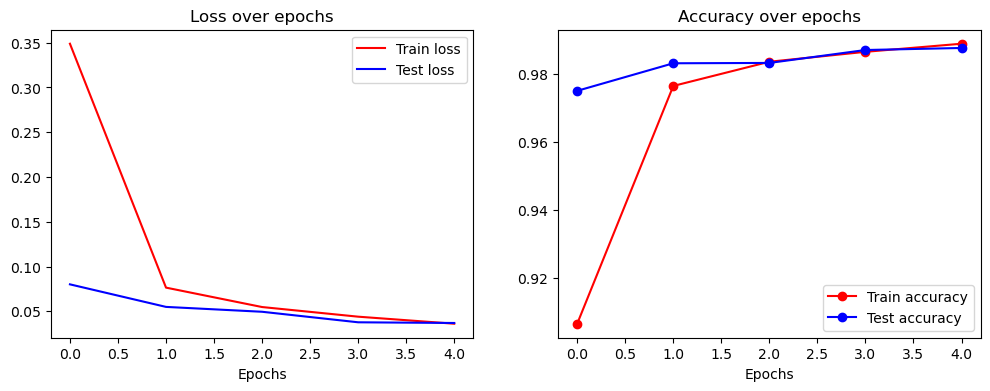

In [14]:
torch.manual_seed(0)

model = BasePoolingCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Baseline CNN with Padding
    (2 conv + 2FC) with padding=2

In [17]:
class BasePaddingCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3, padding=2) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2) 
                
        self.fc1 = nn.Linear(64*32*32, 128) # flatten conv output
        self.fc2 = nn.Linear(128, 10) # output set to 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        # print(x.shape)
        
        x = F.relu(self.conv2(x)) # ReLU function for layer 2
        # print(x.shape)
 
        x = x.view(x.size(0), -1) # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        # print(x.shape)

        x = self.fc2(x) # final output [batch, 10]
        return x

Epoch 1 done. Average train loss = 0.28, average train accuracy = 91.405%
Epoch 1 done. Average test loss = 0.06, average test accuracy = 98.200%
Epoch 2 done. Average train loss = 0.05, average train accuracy = 98.408%
Epoch 2 done. Average test loss = 0.05, average test accuracy = 98.450%
Epoch 3 done. Average train loss = 0.03, average train accuracy = 99.058%
Epoch 3 done. Average test loss = 0.04, average test accuracy = 98.600%
Epoch 4 done. Average train loss = 0.02, average train accuracy = 99.418%
Epoch 4 done. Average test loss = 0.04, average test accuracy = 98.690%
Epoch 5 done. Average train loss = 0.01, average train accuracy = 99.572%
Epoch 5 done. Average test loss = 0.04, average test accuracy = 98.850%


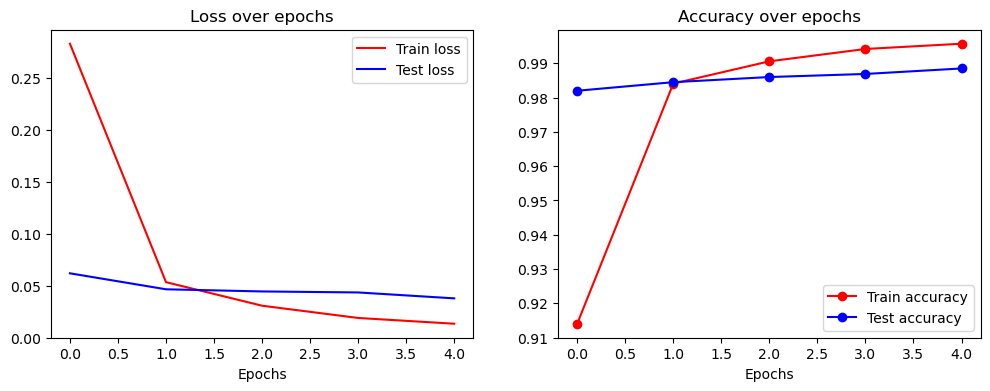

In [18]:
torch.manual_seed(0)

model = BasePaddingCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Baseline CNN with Stride
    (2 conv + 2FC) with stride=2

In [19]:
class BaseStrideCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2) 
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2) 
                
        self.fc1 = nn.Linear(64*6*6, 128) # flatten conv output
        self.fc2 = nn.Linear(128, 10) # output set to 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        # print(x.shape)
        
        x = F.relu(self.conv2(x)) # ReLU function for layer 2
        # print(x.shape)
 
        x = x.view(x.size(0), -1) # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        # print(x.shape)

        x = self.fc2(x) # final output [batch, 10]
        return x

Epoch 1 done. Average train loss = 0.42, average train accuracy = 88.020%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 95.980%
Epoch 2 done. Average train loss = 0.11, average train accuracy = 96.855%
Epoch 2 done. Average test loss = 0.07, average test accuracy = 97.710%
Epoch 3 done. Average train loss = 0.07, average train accuracy = 98.142%
Epoch 3 done. Average test loss = 0.05, average test accuracy = 98.160%
Epoch 4 done. Average train loss = 0.05, average train accuracy = 98.548%
Epoch 4 done. Average test loss = 0.05, average test accuracy = 98.340%
Epoch 5 done. Average train loss = 0.04, average train accuracy = 98.798%
Epoch 5 done. Average test loss = 0.04, average test accuracy = 98.690%


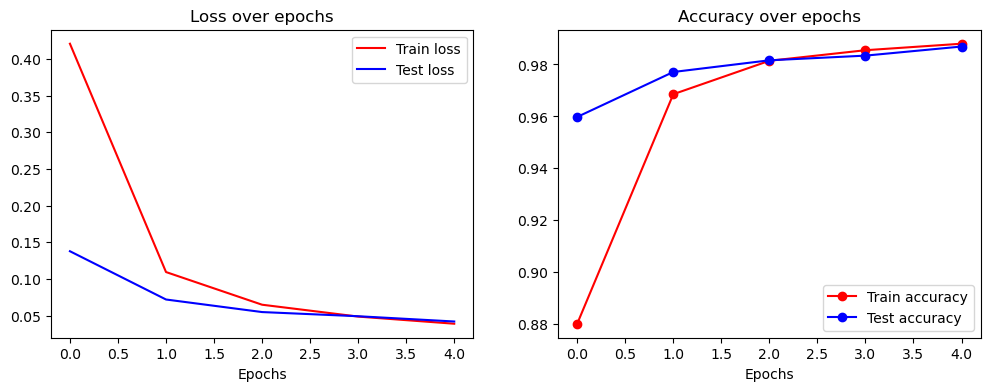

In [21]:
torch.manual_seed(0)

model = BaseStrideCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Baseline CNN with Dilation
    (2 conv + 2FC) with dilation=2


In [ ]:
class BaseDilationCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 3, dilation=2) 
        self.conv2 = nn.Conv2d(32, 64, 3, dilation=2) 
                
        self.fc1 = nn.Linear(64*4*4, 128)  # flatten conv output
        self.fc2 = nn.Linear(128, 10)      # output set to 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU function for layer 1
        x = F.relu(self.conv2(x)) # ReLU function for layer 2
        x = x.view(x.size(0), -1) # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # final output [batch, 10]
        return x

Epoch 1 done. Average train loss = 0.41, average train accuracy = 88.950%
Epoch 1 done. Average test loss = 0.12, average test accuracy = 96.390%
Epoch 2 done. Average train loss = 0.10, average train accuracy = 97.112%
Epoch 2 done. Average test loss = 0.07, average test accuracy = 98.030%
Epoch 3 done. Average train loss = 0.07, average train accuracy = 98.038%
Epoch 3 done. Average test loss = 0.05, average test accuracy = 98.430%
Epoch 4 done. Average train loss = 0.05, average train accuracy = 98.415%
Epoch 4 done. Average test loss = 0.04, average test accuracy = 98.640%
Epoch 5 done. Average train loss = 0.04, average train accuracy = 98.655%
Epoch 5 done. Average test loss = 0.04, average test accuracy = 98.810%


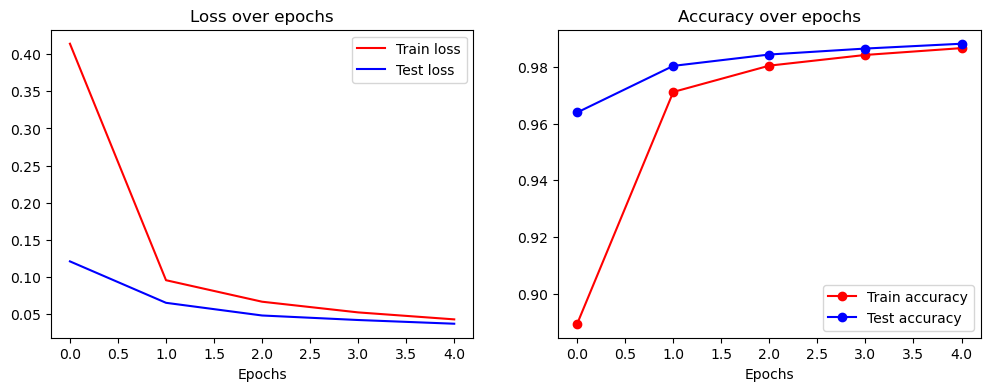

In [ ]:
torch.manual_seed(0)

model = BaseDilationCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()

### Deeper CNN 
    (4 conv + 2FC) with padding=1, Pooling=(2,2)

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # Convolutional layers
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 32, 3)
        self.pool = nn.MaxPool2d(2, 2) # Pooling layer
        
        self.fc1 = nn.Linear(32*7*7, 128) # Fully connected layers
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))  # now shape [batch, 32, 7, 7]
        
        x = x.view(x.size(0), -1) # Flatten # [batch, 32*7*7]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)            # final output [batch, 10]
        
        return x

Epoch 1 done. Average train loss = 0.37, average train accuracy = 88.482%
Epoch 1 done. Average test loss = 0.07, average test accuracy = 97.800%
Epoch 2 done. Average train loss = 0.07, average train accuracy = 97.968%
Epoch 2 done. Average test loss = 0.05, average test accuracy = 98.200%
Epoch 3 done. Average train loss = 0.05, average train accuracy = 98.567%
Epoch 3 done. Average test loss = 0.04, average test accuracy = 98.830%
Epoch 4 done. Average train loss = 0.03, average train accuracy = 98.912%
Epoch 4 done. Average test loss = 0.04, average test accuracy = 98.640%
Epoch 5 done. Average train loss = 0.03, average train accuracy = 99.160%
Epoch 5 done. Average test loss = 0.03, average test accuracy = 99.150%


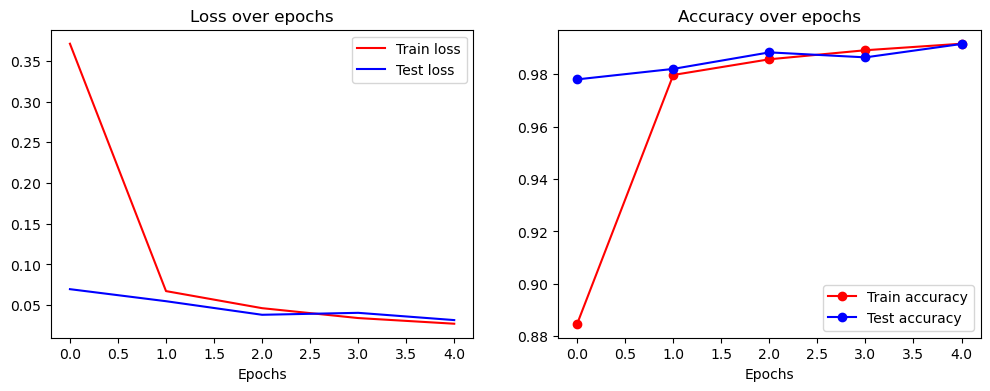

In [ ]:
torch.manual_seed(0)

model = DeeperCNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# Training Loop
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# Plot
plot(train_losses, test_losses, train_metrics,test_metrics)
plt.show()